In [40]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
import re
import json
import time
import warnings
from wordcloud import WordCloud, STOPWORDS

## NLP operation on text
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# To consume Twitter's API
import tweepy
from tweepy import Stream
from tweepy import StreamListener
from secrets import consumer_key, consumer_secret, access_key, access_secret


# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

# Clean the text
import preprocessor as prep


# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Jae/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
print('Which keyword you want to check on real-time twitter?')
print('e.g. if you are looking for opinions on iphone 12,')
print('insert such as iphone AND galaxy')
KEYWORDS = input()

Which keyword you want to check on real-time twitter?
e.g. if you are looking for opinions on iphone 12,
insert such as iphone AND galaxy


 Trump


In [3]:
KEYWORDS

'Trump'

In [4]:
# rename the output file. 
OUTPUT_NAME=re.sub("AND | OR", "_", KEYWORDS.replace('"',"")).replace(' ', "")
OUTPUT_FILE = OUTPUT_NAME+".csv"
# number of tweets to capture.
TWEETS_TO_CAPTURE = 10

In [5]:
class MyStreamListener(tweepy.StreamListener):
    def __init__(self, api=None):
        super(MyStreamListener, self).__init__()
        self.num_tweets = 0
        self.file = open(OUTPUT_FILE, 'w')

    def on_status(self, status):
        tweet = status._json
        self.file.write(json.dumps(tweet)+'\n')
        self.num_tweets += 1

        # Stops streaming when it reaches the limit
        if self.num_tweets <= TWEETS_TO_CAPTURE:
            if self.num_tweets %100 ==0:
                print(f'Numbers of tweets caught so far: {self.num_tweets}')
            return True
        else:
            return False
        self.file.close()

    def on_error(self, status):
        print("Error detected")


In [6]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret) 
api = tweepy.API(auth, wait_on_rate_limit=True,
                wait_on_rate_limit_notify=True)
tweets_listener = MyStreamListener()
stream = tweepy.Stream(api.auth, tweets_listener)

In [7]:
stream.filter(track=[KEYWORDS], languages=["en"])


In [8]:
# Initialize empty list to store tweets
tweets_data = []

# Open connection to file
with open(OUTPUT_FILE, "r") as tweets_file:
    # Read in tweets and store in list
    for line in tweets_file:
        tweet = json.loads(line)
        tweets_data.append(tweet)
        

In [9]:
def id_extractor(data: list):
    name_list = []
    for i in range (len(data)):
        name_list.append(data[i]['user']['screen_name'])
    return pd.DataFrame(name_list)

In [10]:
user_names = id_extractor(tweets_data)
user_names

,0
0,DrRickF
1,PauliePops1
2,TheRealAZJhawks
3,PainterMom101
4,YouEndorse
5,ICBubbleGum
6,tahitianspecial
7,CrystalScurr
8,Qnited_We_Stand
9,SassyP100


In [11]:
def clean_tweet(tweet): 
        ''' 
        To clean tweet text by removing links, special characters 
        '''
        cleaned_tweet = ' '.join(re.sub("(@[A-Za-z0-9]+) | ([^0-9A-Za-z \t]) | (\w+:\/\/\S+)",
                                        " ", tweet).split())
        return cleaned_tweet

In [12]:
def full_text_extractor(data: list):
    '''
    To extract full text from each user.
    '''
    full_text_list = []
    for i in range (len(data)):
        # if there is 'extended_tweet', clean the full_text and append it to the full_text_list.
        if tweets_data[i].__contains__('extended_tweet'):
            full_text_list.append(clean_tweet(tweets_data[i]['extended_tweet']['full_text']))
        # if there is 'retweeted_status' and extended_tweet in it, clean the full_text and  
        # append it to the full_text_list. Otherwise, clean and append the text. 
        elif tweets_data[i].__contains__('retweeted_status'):
            if tweets_data[i]['retweeted_status'].__contains__('extended_tweet'):
                full_text_list.append(clean_tweet(clean_tweet(tweets_data[i]['retweeted_status']['extended_tweet']['full_text'])))
            else:
                full_text_list.append(clean_tweet(clean_tweet(tweets_data[i]['text'])))
        else:
            full_text_list.append(clean_tweet(tweets_data[i]['text']))
    return pd.DataFrame(full_text_list)

In [13]:
# To check what the full_texts is.
full_texts=full_text_extractor(tweets_data)
print(full_texts)

                                                    0
0   Speaking of yard signs- i’ve been seeing Trump...
1   RT @catturd2: President Trump owned the Democr...
2   Every single eligible American should have the...
3   From a friend: An anguished question from a Tr...
4   RT @TheOnion: Trump Slaughters Dozens Of Ameri...
5   RT @TweetSusieTweet: Trump on Mount Rushmore. ...
6   Trump is about to cut out the middlemen in pha...
7                                  No matter what YES
8   RT @RealBrysonGray: Keep sharing this to make ...
9   RT @RyanAFournier: Trump: Authorizes $430 mill...
10  RT @thekjohnston: This is why trump built appr...


In [14]:
df = pd.DataFrame(tweets_data, columns=['created_at','lang', 'text'])
# store user names
df['user_name']=user_names
# replace texts with full texts if there is any
df['text']=full_texts
# convert to datetime
df['created_at'] = pd.to_datetime(df.created_at)
df.text[5]

'RT @TweetSusieTweet: Trump on Mount Rushmore. Cheers from Australia! Credit: @moir_alan'

In [15]:
def textblob_analyzer(tweet): 
        ''' 
        To classify sentiment positive, negative, or neutral  
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(tweet) 

        #analysis = TextBlob(self.clean_tweet(tweet), analyzer=NaiveBayesAnalyzer()) 
        
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        elif analysis.sentiment.polarity < 0: 
            return 'negative'
        elif analysis.sentiment.polarity == 0: 
            return 'neutral'

In [16]:
sid = SentimentIntensityAnalyzer()
def get_vader_score(tweet):
    # Polarity score returns dictionary
    score = sid.polarity_scores(tweet)
    return score

In [17]:
def vader_analyzer(tweet): 
        ''' 
        To classify sentiment positive, negative, or neutral  
        '''
        # create TextBlob object of passed tweet text  
        score = get_vader_score(tweet)['compound']
        
        # set sentiment 
        if score >= 0.05: 
            return 'positive'
        elif score <= -0.05: 
            return 'negative'
        else: 
            return 'neutral'

In [18]:
print(len(df))
df.head(3)

11


,created_at,lang,text,user_name
0,2020-08-10 06:57:25+00:00,en,Speaking of yard signs- i’ve been seeing Trump...,DrRickF
1,2020-08-10 06:57:25+00:00,en,RT @catturd2: President Trump owned the Democr...,PauliePops1
2,2020-08-10 06:57:25+00:00,en,Every single eligible American should have the...,TheRealAZJhawks


In [19]:
# See how the df looks.
df['TextBlob']=df['text'].apply(lambda tweet: textblob_analyzer(tweet))
df['Vader']=df['text'].apply(lambda tweet: vader_analyzer(tweet))
df

,created_at,lang,text,user_name,TextBlob,Vader
0,2020-08-10 06:57:25+00:00,en,Speaking of yard signs- i’ve been seeing Trump...,DrRickF,positive,positive
1,2020-08-10 06:57:25+00:00,en,RT @catturd2: President Trump owned the Democr...,PauliePops1,positive,negative
2,2020-08-10 06:57:25+00:00,en,Every single eligible American should have the...,TheRealAZJhawks,positive,positive
3,2020-08-10 06:57:25+00:00,en,From a friend: An anguished question from a Tr...,PainterMom101,negative,positive
4,2020-08-10 06:57:25+00:00,en,RT @TheOnion: Trump Slaughters Dozens Of Ameri...,YouEndorse,neutral,positive
5,2020-08-10 06:57:25+00:00,en,RT @TweetSusieTweet: Trump on Mount Rushmore. ...,ICBubbleGum,neutral,positive
6,2020-08-10 06:57:25+00:00,en,Trump is about to cut out the middlemen in pha...,tahitianspecial,positive,negative
7,2020-08-10 06:57:25+00:00,en,No matter what YES,CrystalScurr,neutral,positive
8,2020-08-10 06:57:25+00:00,en,RT @RealBrysonGray: Keep sharing this to make ...,Qnited_We_Stand,negative,positive
9,2020-08-10 06:57:25+00:00,en,RT @RyanAFournier: Trump: Authorizes $430 mill...,SassyP100,negative,negative


In [20]:
# Two analysis
textBlob_results=df.TextBlob.value_counts().sort_index(ascending=False)
if textBlob_results.__contains__('positive')==False:
    textBlob_results['positive'] = 0
if textBlob_results.__contains__('negative')==False:
    textBlob_results['negative'] = 0
if textBlob_results.__contains__('neutral')==False:
    textBlob_results['neutral'] = 0
if textBlob_results.positive == len(df):
    textBlob_results['negative'] = 0
    textBlob_results['neutral'] = 0
if textBlob_results.negative == len(df):
    textBlob_results['positve'] = 0
    textBlob_results['neutral'] = 0
if textBlob_results.neutral == len(df):
    textBlob_results['positve'] = 0
    textBlob_results['neutral'] = 0

    
Vader_results=df.Vader.value_counts().sort_index(ascending=False)
if Vader_results.__contains__('positive')==False:
    Vader_results['positive'] = 0
if Vader_results.__contains__('negative')==False:
    Vader_results['negative'] = 0
if Vader_results.__contains__('neutral')==False:
    Vader_results['neutral'] = 0
if Vader_results.positive == len(df):
    Vader_results['negative'] = 0
    Vader_results['neutral'] = 0
if Vader_results.negative == len(df):
    Vader_results['positve'] = 0
    Vader_results['neutral'] = 0
if Vader_results.neutral == len(df):
    Vader_results['positve'] = 0
    Vader_results['neutral'] = 0



In [21]:
textBlob_results

positive    4
neutral     4
negative    3
Name: TextBlob, dtype: int64

In [23]:
Vader_results

positive    7
neutral     1
negative    3
Name: Vader, dtype: int64

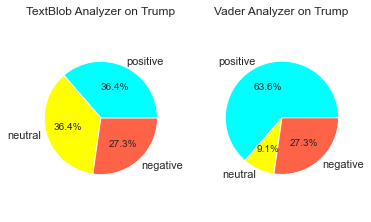

In [24]:
#plot Pie plot.
if len(df) != 0:
    fig, ax = plt.subplots(1,2)
    label_list=['positive','neutral','negative']
    colors_emotion = ['cyan','yellow','tomato']
    explodes_emotion = [0,0,0]
    #axis 1 for TextBlob analyzer
    ax[0].pie(list(textBlob_results),labels=label_list,colors=colors_emotion,explode=explodes_emotion,
            autopct='%1.1f%%', shadow=False)
    ax[0].set_title(f'TextBlob Analyzer on {KEYWORDS}')
    ax[0].axis('equal')
    #axis 2 for Vader analyzer
    ax[1].pie(list(Vader_results),labels=label_list,colors=colors_emotion,explode=explodes_emotion,
            autopct='%1.1f%%', shadow=False)
    ax[1].set_title(f'Vader Analyzer on {KEYWORDS}')
    ax[1].axis('equal')
    fig.tight_layout(pad=4.0)
    plt.show()

In [25]:
# tested some samples and relaized that vader is 
# generally better for sentiment analysis.
# so, group the people who have the similar opinions on 
# keyword. 
pos_group=df[df['Vader']=='positive']
neg_group=df[df['Vader']=='negative']
neut_group=df[df['Vader']=='neutral']

# want to 

In [27]:
pos_group

,created_at,lang,text,user_name,TextBlob,Vader
0,2020-08-10 06:57:25+00:00,en,Speaking of yard signs- i’ve been seeing Trump...,DrRickF,positive,positive
2,2020-08-10 06:57:25+00:00,en,Every single eligible American should have the...,TheRealAZJhawks,positive,positive
3,2020-08-10 06:57:25+00:00,en,From a friend: An anguished question from a Tr...,PainterMom101,negative,positive
4,2020-08-10 06:57:25+00:00,en,RT @TheOnion: Trump Slaughters Dozens Of Ameri...,YouEndorse,neutral,positive
5,2020-08-10 06:57:25+00:00,en,RT @TweetSusieTweet: Trump on Mount Rushmore. ...,ICBubbleGum,neutral,positive
7,2020-08-10 06:57:25+00:00,en,No matter what YES,CrystalScurr,neutral,positive
8,2020-08-10 06:57:25+00:00,en,RT @RealBrysonGray: Keep sharing this to make ...,Qnited_We_Stand,negative,positive


In [29]:
# Check a text in the positive group
pos_group.text[2]

"Every single eligible American should have the opportunity to vote-by-mail this November. If it's good enough for Donald Trump then it's good enough for you and me."

In [41]:
Vstart = time.time()
print(f'Vader: {get_vader_score(pos_group.text[2])}')
Vend = time.time()
print('vs')
Tstart = time.time()
print(f'TextBlob: {TextBlob(pos_group.text[2]).sentiment}')
Tend = time.time()
print('vs')
Nstart = time.time()
print(f'TextBlob w/ NB: {TextBlob(pos_group.text[2], analyzer=NaiveBayesAnalyzer()).sentiment}')
Nend = time.time()

Vader: {'neg': 0.0, 'neu': 0.736, 'pos': 0.264, 'compound': 0.8225}
vs
TextBlob: Sentiment(polarity=0.22142857142857142, subjectivity=0.40238095238095245)
vs
TextBlob w/ NB: Sentiment(classification='pos', p_pos=0.7772960377509671, p_neg=0.22270396224903263)


In [42]:
print(f'Vader: {Vend-Vstart} s, TextBlob: {Tend-Tstart} s, TextBlob: {Nend-Nstart} s')

Vader: 0.0016090869903564453 s, TextBlob: 0.0011258125305175781 s, TextBlob: 4.698314905166626 s


The text can be positive, but more like neutral. If the condition is changed for neutrality, Vader seems better. Moreover, despite the duration TextBlob without NB is the fastest, Vader is useful for the sentiment analysis tasks like movie review or book review. 

In [28]:
neg_group.text

,created_at,lang,text,user_name,TextBlob,Vader
1,2020-08-10 06:57:25+00:00,en,RT @catturd2: President Trump owned the Democr...,PauliePops1,positive,negative
6,2020-08-10 06:57:25+00:00,en,Trump is about to cut out the middlemen in pha...,tahitianspecial,positive,negative
9,2020-08-10 06:57:25+00:00,en,RT @RyanAFournier: Trump: Authorizes $430 mill...,SassyP100,negative,negative


In [45]:
words=neg_group.text[6]
words

'Trump is about to cut out the middlemen in pharmaceutical markets. This is huge Right after announcing that, he says “So I have a lot of enemies out there, this may be the last time you see me for awhile.” Is he saying big pharma is plotting to kill him?'

The text can be neutral or negative. Vader seems better for analysis.

Let's look at what the user of this guys who wrote above think.

(-0.5, 399.5, 199.5, -0.5)

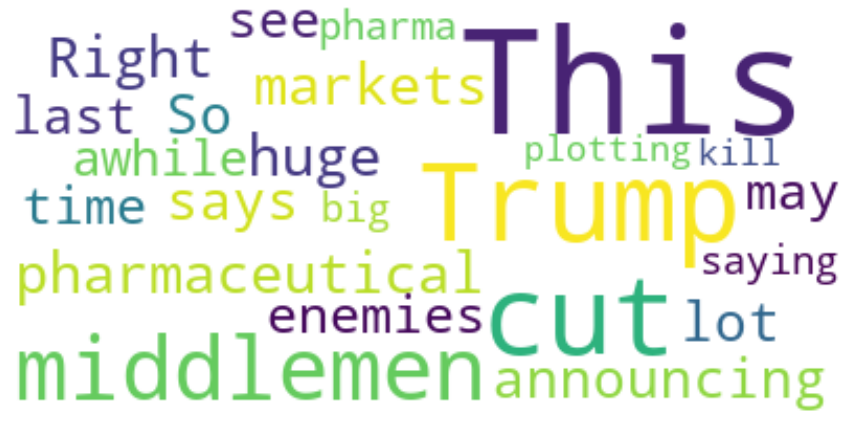

In [46]:
stopwords = set(STOPWORDS) # pre-defined words to ignore
# adding extra words to ignore: 
# many tweets contain RT in the text, and we know the tweets are about Donald Trump
stopwords.update([KEYWORDS]) 
wordcloud = (WordCloud(background_color="white", # easier to read
                      max_words=50, # let's no polute it too much
                      stopwords=stopwords) # define words to ignore
                      .generate(words)) # generate the wordcloud with text
plt.figure(figsize=(15,10)) # make the plot bigger
# Show the plot (interpolation='bilinear' makes it better looking)
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 